In [1]:
ROOT_PATH = '../../../../'
# MNIST_DATA_PATH = ROOT_PATH + 'assets/data/morphomnist_reversed_pgm/'
# BASE_LOG_PATH = ROOT_PATH + 'assets/models/morphomnist_reversed_pgm/'

import sys
import os
import inspect
from collections import OrderedDict
from functools import partial

sys.path.append(ROOT_PATH)

import pyro
import torch
import torch.nn.functional as F
import torch_geometric.nn as gnn
import torch_geometric.transforms as gnn_T
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import tqdm
import pandas as pd
from torch_cluster import grid_cluster
from torch_geometric.data import DataLoader
from skimage.color import gray2rgba
from PIL import Image, ImageDraw
from torch_geometric.data import Data
from torch import Tensor

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [3]:
%matplotlib inline

## Setup and Data Inspection

In [4]:
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), interpolation='nearest')

In [355]:
def mnist_graph_image(graph: Data, scale: int, rescale: int) -> Image:
    img = graph.x.detach().clone()
    index = graph.edge_index.detach().clone()
    position = graph.pos.detach().clone()
    
    offset = torch.FloatTensor([
        (28 - position[:, 0].max()) / 2, 
        (28 - position[:, 1].max()) / 2
    ])
    
    position *= (scale * offset)
    position += (scale * offset * rescale)
    
    image = np.ones((28, 28), np.uint8)
    image = np.repeat(image, scale * rescale, axis=0)
    image = np.repeat(image, scale * rescale, axis=1)
    image = gray2rgba(image)
    image *= np.array([255, 255, 255, 1], np.uint8)
    image = Image.fromarray(image)
    draw = ImageDraw.Draw(image)

    for i in range(index.size(1)):
        start, end = index[:, i].t()
        start_x, start_y = position[start]
        end_x, end_y = position[end]
        start_x, start_y = int(start_x), int(start_y)
        end_x, end_y = int(end_x), int(end_y)
        draw.line(
            (start_x, start_y, end_x, end_y),
            fill=(0, 0, 0, 255),
            width=rescale * 2
        )
        
    for i in range(graph['pos'].size(0)):
        x, y = position[i]
        r = 5 * rescale
        draw.ellipse(
            (x - r, y - r, x + r, y + r),
            fill=(0, 0, 0, 255)
        )
        r = 14 * rescale
        draw.ellipse(
            (x - r, y - r, x + r, y + r),
            fill=(49, 130, 219, int(255 * img[i])),
            outline='black'
        )
        
    image = image.resize((28 * scale, 28 * scale), Image.ANTIALIAS)
    return image

In [356]:
from torch_geometric.datasets import MNISTSuperpixels

graph_train_dataset = MNISTSuperpixels(root='./MNIST/graphs/', train=True)

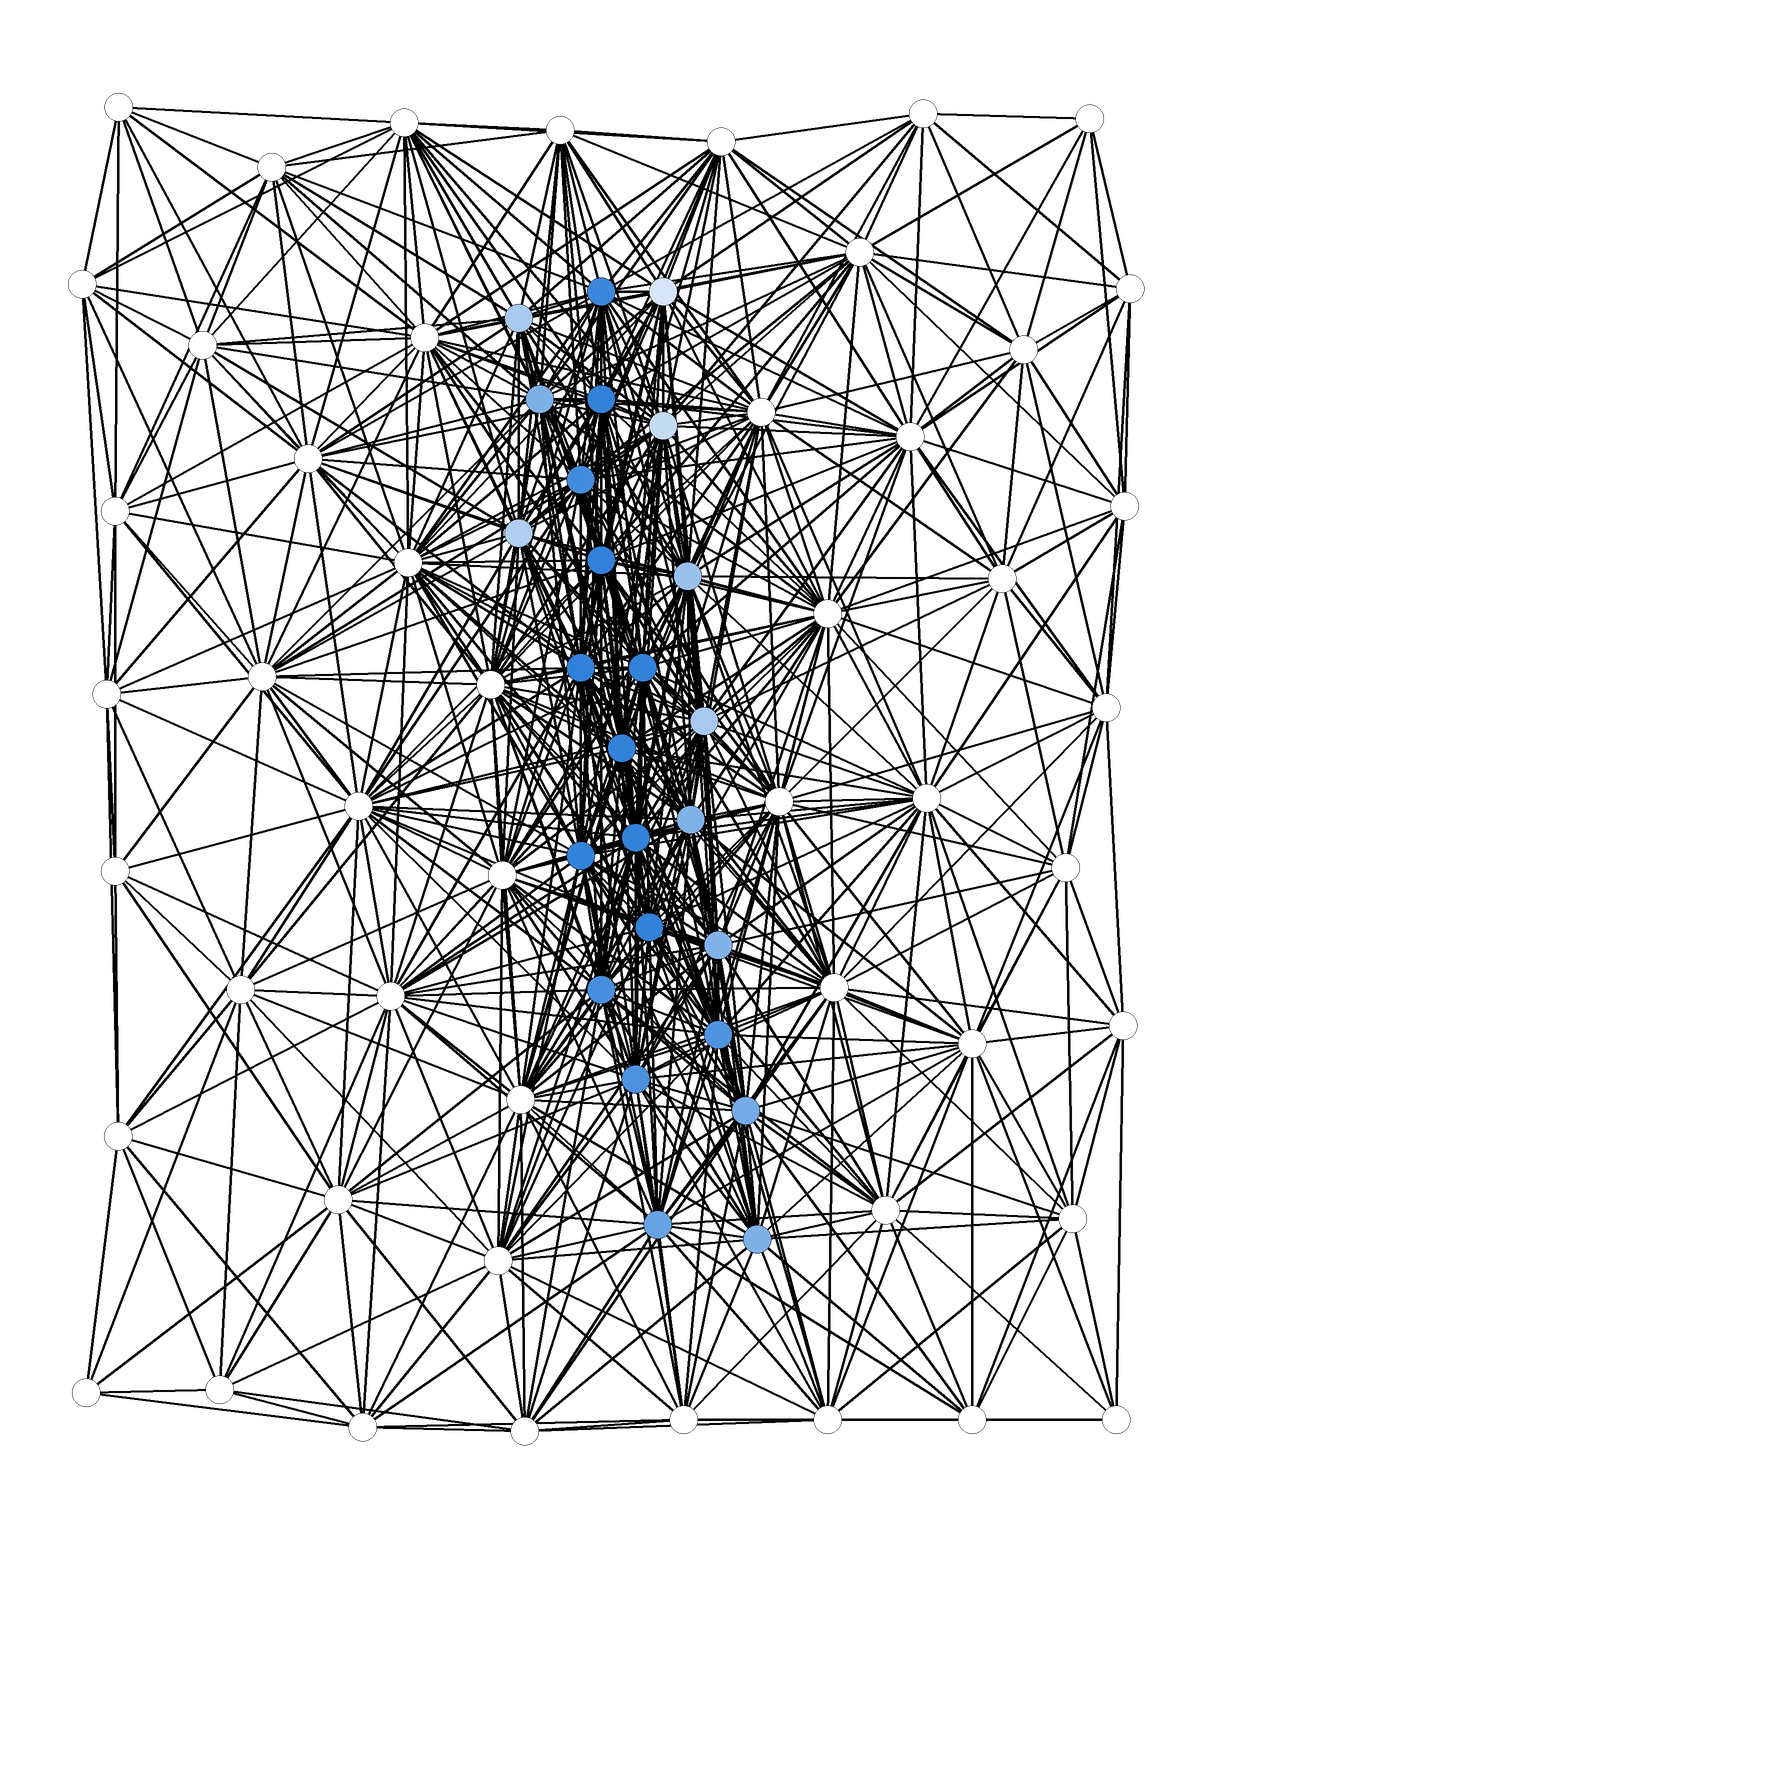

In [357]:
scale = 64
rescale = 2
idx = 6

data = graph_train_dataset[idx]

graph_img = mnist_graph_image(data, scale, rescale)
graph_img

In [104]:
!pip install networkx

In [359]:
import networkx as nx
from torch_geometric.utils import to_dense_batch, to_networkx

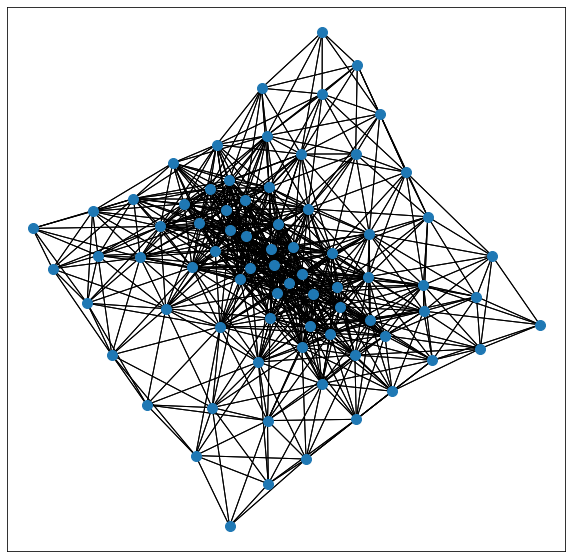

In [361]:
plt.figure(figsize=(10, 10))
nx_G = to_networkx(data)
pos = nx.spring_layout(nx_G)
nx.draw_networkx_nodes(nx_G, pos, node_size=100)
nx.draw_networkx_edges(nx_G, pos, arrows=False)
plt.show()

## Classifier Model

In [20]:
class Net(torch.nn.Module):
    """
    Implementation from Kipf and Welling GCN
    """
    def __init__(self, num_node_features, num_classes):
        super(Net, self).__init__()
        self.conv1 = gnn.GCNConv(num_node_features, 16)
        self.conv2 = gnn.GCNConv(16, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        
        x = self.conv1(x, edge_index)
        x = F.dropout(x, training=self.training)
        x = F.relu(x)
        
        x = self.conv2(x, edge_index)
        x = F.dropout(x, training=self.training)

        return F.log_softmax(x, dim=1)

In [21]:
from torch_geometric.data import Data, Batch


class SplineCNN(torch.nn.Module):
    def __init__(self):
        super(SplineCNN, self).__init__()
        self.conv1 = gnn.SplineConv(1, 32, dim=2, kernel_size=5)
        self.conv2 = gnn.SplineConv(32, 64, dim=2, kernel_size=5)
        self.fc1 = torch.nn.Linear(64, 128)
        self.fc2 = torch.nn.Linear(128, 10)

    def forward(self, data):
        x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch
        
        x = F.elu(self.conv1(x, edge_index, edge_attr))
        x = F.dropout(x, p=0.5)
        cluster = gnn.graclus(edge_index, num_nodes=x.size(0))
        data = Batch(x=x, edge_index=edge_index, edge_attr=edge_attr, batch=batch)
        data = gnn.max_pool(cluster, data)
        
        x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch
        
        x = F.elu(self.conv2(x, edge_index, edge_attr))
        x = F.dropout(x, p=0.5)
        cluster = gnn.graclus(edge_index, num_nodes=x.size(0))
        data = Batch(x=x, edge_index=edge_index, edge_attr=edge_attr, batch=batch)
        data = gnn.max_pool(cluster, data)
        
        x, batch = data.x, data.batch
        
        x = gnn.global_mean_pool(x, batch)  
        x = F.elu(self.fc1(x))
        x = self.fc2(x)
        
        return F.log_softmax(x, dim=1)

In [22]:
preprocess = T.Compose([
    T.Cartesian(),
    T.ToSparseTensor(remove_edge_index=False),
    T.ToUndirected(),
])

In [23]:
from torch_geometric.data import DataLoader

batch_size = 2
graph_train_loader = DataLoader(graph_train_dataset, batch_size=batch_size, shuffle=False)

for x in graph_train_loader:
    print(x)
    print(x.batch)
    break
    
spline_cnn = SplineCNN().to(device)

_data = preprocess(x.to(device))

spline_cnn(_data)

Batch(batch=[150], edge_index=[2, 2659], pos=[150, 2], x=[150, 1], y=[2])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1])


tensor([[-2.3898, -2.2044, -2.4424, -2.2947, -2.2168, -2.2556, -2.3644, -2.3194,
         -2.3911, -2.1833],
        [-2.3907, -2.2035, -2.4438, -2.2945, -2.2169, -2.2558, -2.3642, -2.3191,
         -2.3911, -2.1829]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)

In [24]:
# GCN
# num_node_features = graph_train_dataset.num_node_features
# num_classes = graph_train_dataset.num_classes
# model = Net(num_node_features, num_classes).to(device)

# SplineCNN
model = SplineCNN().to(device)
model

SplineCNN(
  (conv1): SplineConv(1, 32, dim=2)
  (conv2): SplineConv(32, 64, dim=2)
  (fc1): Linear(in_features=64, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [29]:
lr = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

epochs = 30

train_frac = 0.8
train_idx = int(len(graph_train_dataset) * train_frac)
train_split = graph_train_dataset[:train_idx]
val_split = graph_train_dataset[train_idx:]

batch_size = 64
graph_train_loader = DataLoader(train_split, batch_size=batch_size, shuffle=False)  # , prefetch_factor=4)
graph_val_loader = DataLoader(val_split, batch_size=batch_size, shuffle=False)  # , prefetch_factor=4)

In [30]:
def train_model(model, train_dataset_loader, preprocessor):
    model.train()
    
    for batch in tqdm.tqdm(train_dataset_loader):
        optimizer.zero_grad()
        batch = preprocessor(batch.to(device))
        out = model(batch)
        loss = F.nll_loss(out, batch.y)
        loss.backward()
        optimizer.step()
    
    return model
    

def validate_model(model, val_dataset_loader, preprocessor):
    model.eval()
    
    val_acc = []
    
    for batch in val_dataset_loader:
        batch = preprocessor(batch.to(device))
        pred_logits = model(batch)
        _, pred = pred_logits.max(dim=1)
        acc = (pred.eq(batch.y).sum() / batch.y.size(0)).item()
        val_acc.append(acc)
    
    return sum(val_acc) / len(val_acc)

In [31]:
for epoch in range(epochs):
    
    print(f'Epoch: {epoch}')
        
    train_model(model, graph_train_loader, preprocess)
    val_acc = validate_model(model, graph_val_loader, preprocess)
    train_acc = validate_model(model, graph_train_loader, preprocess)
    
    print(f'Train Acc: {train_acc}, Val Acc: {val_acc}')
    print()

  0%|          | 3/750 [00:00<00:32, 22.73it/s]

Epoch: 0


  0%|          | 3/750 [00:00<00:26, 28.64it/s]

Train Acc: 0.7592083333333334, Val Acc: 0.7670378989361702

Epoch: 1


  0%|          | 3/750 [00:00<00:26, 27.89it/s]

Train Acc: 0.7754791666666667, Val Acc: 0.7824135638297872

Epoch: 2


  0%|          | 3/750 [00:00<00:25, 29.56it/s]

Train Acc: 0.7600625, Val Acc: 0.7647938829787234

Epoch: 3


  0%|          | 3/750 [00:00<00:28, 26.63it/s]

Train Acc: 0.760375, Val Acc: 0.7707779255319149

Epoch: 4


  0%|          | 3/750 [00:00<00:26, 27.78it/s]

Train Acc: 0.7602291666666666, Val Acc: 0.765126329787234

Epoch: 5


  0%|          | 3/750 [00:00<00:25, 29.09it/s]

Train Acc: 0.78775, Val Acc: 0.7930518617021277

Epoch: 6


  0%|          | 3/750 [00:00<00:26, 28.52it/s]

Train Acc: 0.7838125, Val Acc: 0.7835771276595744

Epoch: 7


  0%|          | 3/750 [00:00<00:26, 28.53it/s]

Train Acc: 0.8095833333333333, Val Acc: 0.8160738031914894

Epoch: 8


  0%|          | 3/750 [00:00<00:25, 29.56it/s]

Train Acc: 0.783125, Val Acc: 0.7931349734042553

Epoch: 9


  0%|          | 3/750 [00:00<00:25, 29.22it/s]

Train Acc: 0.8229583333333333, Val Acc: 0.8267121010638298

Epoch: 10


  0%|          | 3/750 [00:00<00:25, 28.96it/s]

Train Acc: 0.8234375, Val Acc: 0.8277925531914894

Epoch: 11


  0%|          | 3/750 [00:00<00:26, 27.90it/s]

Train Acc: 0.8174375, Val Acc: 0.8207280585106383

Epoch: 12


  0%|          | 3/750 [00:00<00:27, 27.12it/s]

Train Acc: 0.8122916666666666, Val Acc: 0.8194813829787234

Epoch: 13


  0%|          | 3/750 [00:00<00:24, 29.98it/s]

Train Acc: 0.8305625, Val Acc: 0.828374335106383

Epoch: 14


  0%|          | 3/750 [00:00<00:26, 28.70it/s]

Train Acc: 0.8330833333333333, Val Acc: 0.8410904255319149

Epoch: 15


  0%|          | 3/750 [00:00<00:25, 29.46it/s]

Train Acc: 0.8296041666666667, Val Acc: 0.8366023936170213

Epoch: 16


  0%|          | 3/750 [00:00<00:26, 28.67it/s]

Train Acc: 0.8331041666666666, Val Acc: 0.8341921542553191

Epoch: 17


  0%|          | 3/750 [00:00<00:26, 28.71it/s]

Train Acc: 0.8288333333333333, Val Acc: 0.827626329787234

Epoch: 18


  0%|          | 3/750 [00:00<00:25, 28.81it/s]

Train Acc: 0.8312083333333333, Val Acc: 0.8321974734042553

Epoch: 19


  0%|          | 3/750 [00:00<00:25, 29.34it/s]

Train Acc: 0.8370416666666667, Val Acc: 0.8353557180851063

Epoch: 20


  0%|          | 3/750 [00:00<00:25, 28.87it/s]

Train Acc: 0.8326666666666667, Val Acc: 0.8343583776595744

Epoch: 21


  0%|          | 3/750 [00:00<00:25, 28.79it/s]

Train Acc: 0.8357916666666667, Val Acc: 0.8349401595744681

Epoch: 22


  0%|          | 3/750 [00:00<00:25, 29.26it/s]

Train Acc: 0.8321875, Val Acc: 0.8360206117021277

Epoch: 23


  0%|          | 3/750 [00:00<00:26, 27.86it/s]

Train Acc: 0.8372916666666667, Val Acc: 0.8357712765957447

Epoch: 24


  0%|          | 3/750 [00:00<00:25, 28.77it/s]

Train Acc: 0.8475208333333333, Val Acc: 0.8456615691489362

Epoch: 25


  0%|          | 3/750 [00:00<00:27, 26.75it/s]

Train Acc: 0.8416875, Val Acc: 0.8463264627659575

Epoch: 26


  0%|          | 3/750 [00:00<00:25, 29.19it/s]

Train Acc: 0.8471666666666666, Val Acc: 0.8497340425531915

Epoch: 27


  0%|          | 3/750 [00:00<00:27, 27.60it/s]

Train Acc: 0.8324583333333333, Val Acc: 0.8351063829787234

Epoch: 28


  0%|          | 3/750 [00:00<00:25, 29.18it/s]

Train Acc: 0.8431875, Val Acc: 0.8444148936170213

Epoch: 29


100%|██████████| 750/750 [00:30<00:00, 24.82it/s]


Train Acc: 0.8527291666666666, Val Acc: 0.8570478723404256



In [32]:
graph_test_dataset = MNISTSuperpixels(root='./MNIST/graphs', train=False)
graph_test_loader = DataLoader(graph_test_dataset, batch_size=len(graph_test_dataset), shuffle=True)

model.eval()

for x in graph_test_loader:
    pass

_data = preprocess(x.to(device))

pred_logits = model(_data)

In [33]:
_, pred = pred_logits.max(dim=1)
acc = (pred.eq(x.y).sum() / x.y.size(0)).item()
print(acc)

0.8619999885559082
